# Carregar as bibliotecas

In [105]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure
from scipy import ndimage, stats, fft
import matplotlib.pyplot as plt
from skimage.util import img_as_float, img_as_uint, img_as_ubyte
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [106]:
def show(img_list, caption_list, Axis=False, rescale = True):
    n = len(img_list)
    f, ax = plt.subplots(1,n, figsize=(10+5*(n-1),10))
    for i in range(n):
        if rescale:
            ax[i].imshow(img_list[i], cmap='gray')
        else:
            ax[i].imshow(img_list[i], cmap='gray', vmin=0, vmax=255)
        ax[i].set_title(caption_list[i])
        if not Axis:
            ax[i].set_axis_off()

In [107]:
def gridFourier(M, N):
    u = np.arange(0, M)
    v = np.arange(0, N)

    u = u - np.floor(M/2)
    v = v - np.floor(N/2)
    U, V = np.meshgrid(u, v)
    return U, V

In [108]:
def my_mesh(mat):
    lin, col = mat.shape[:2]
    x, y = np.ogrid[0:lin, 0:col]
    ax = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.plot_surface(x, y, mat, rstride=1, cstride=1, cmap='viridis', edgecolor='none');

In [109]:
def mapping(img):
    nimg = util.img_as_float(img)
    mmin = np.min(nimg)
    nimg = nimg - mmin
    mmax = np.max(nimg)
    return (nimg/mmax)*255

In [110]:
def passa_freq(img, mask):
    height, width = img.shape[:2]
    fimg = fft.fftshift( fft.fft2(img) )
    fimg = fimg * mask
    nimg = fft.ifft2(fimg)
    nimg = np.abs(nimg)
    return nimg, fimg

# Questão 1

<p align="justify">
Dada a seguinte imagem, eliminar o ruído produzido pelo ruído periódico. Teste com os seguinte filtros: média, mediana e a filtragem no domínio da frequência. Para o caso da filtragem no domínio da frequência, primeiro calcule o espectro de Fourier (Figura b) e elimine a \textbf{região} ao redor dos ``spikes'' (assinalados com a seta vermelha). Os ``spikes'' estão localizados nas coordenadas (88,88) e (170,170). A terceira imagem mostra o processo depois de apagar esses valores.
Para apagar os valores, basta atribuir zero para todos os elementos da região.
</p>

<p align="justify">

</p>

<table><tr>
<td> <img src="https://drive.google.com/uc?id=1ExhUVoHaj2i4gN1UWC6U7RfP-boZhnRL" alt="Drawing"  width="300"/> </td>
<td> <img src="https://drive.google.com/uc?id=1BGJbV6sXNNlt2PmIZ7RCyHpQfPRpZgJ6" alt="Drawing"  width="300"/> </td>

</tr></table>

<p align"justify">
Filtro notch: São filtros capazes de rejeitar uma faixa bastante estreita de frequências. Sua utilização é recomendada quando o sinal a ser atenuado é bem definido. Pelo fato de atuar em faixas reduzidas de frequências, filtros notch interferem pouco na qualidade do sinal. A figura a continuação mostra apenas um par de regiões sendo retirado.
</p>

<img src="https://drive.google.com/uc?id=1L4J9Y6yFpKMebHyceWb1cy7j6CWljixO" alt="Drawing"  width="300"/>

<p align"justify">
A área em torno da frequência de corte escolhida ($D_0$) que pode ser retirada é definida na construção do filtro. Seja $D_0$ a frequência de corte do filtro notch centrado em ($u_0, v_0$) e, por simetria ($-u_0, -v_0$):

$$D_1(u,v) = \sqrt{(u - M/2 - u_0)^2 + (v - N/2 - v_0)^2}$$

$$D_2(u,v) = \sqrt{(u - M/2 + u_0)^2 + (v - N/2 + v_0)^2}$$

$$H(u,v) = \frac{1}{1 + \left(\frac{D_0^2}{D_1(u,v)D_2(u,v)}\right)^{2n}}$$

Crie um filtro notch para remover a ruído periódico
</p>


In [111]:
def mask_butterworth_notch(width, height, d0, n, u, v):
    U, V = gridFourier(width, height)
    D1 = np.sqrt( (U-u)**2 + (V-v)**2 )
    D2 = np.sqrt( (U+u)**2 + (V+v)**2 )
    H = 1 / (1 + ( (d0**2)/(D1*D2) )**(2*n))
    return H

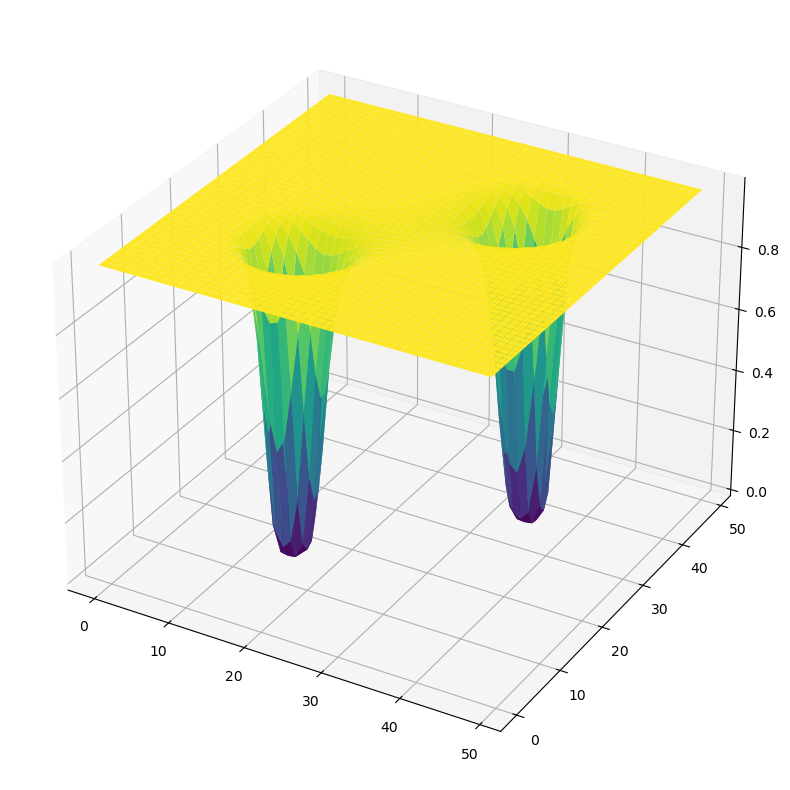

In [112]:
HN = mask_butterworth_notch(50, 50, 10, 3, 10, 10)
my_mesh(HN)
#mshow(HN, cmap='gray',vmin=0, vmax=1)

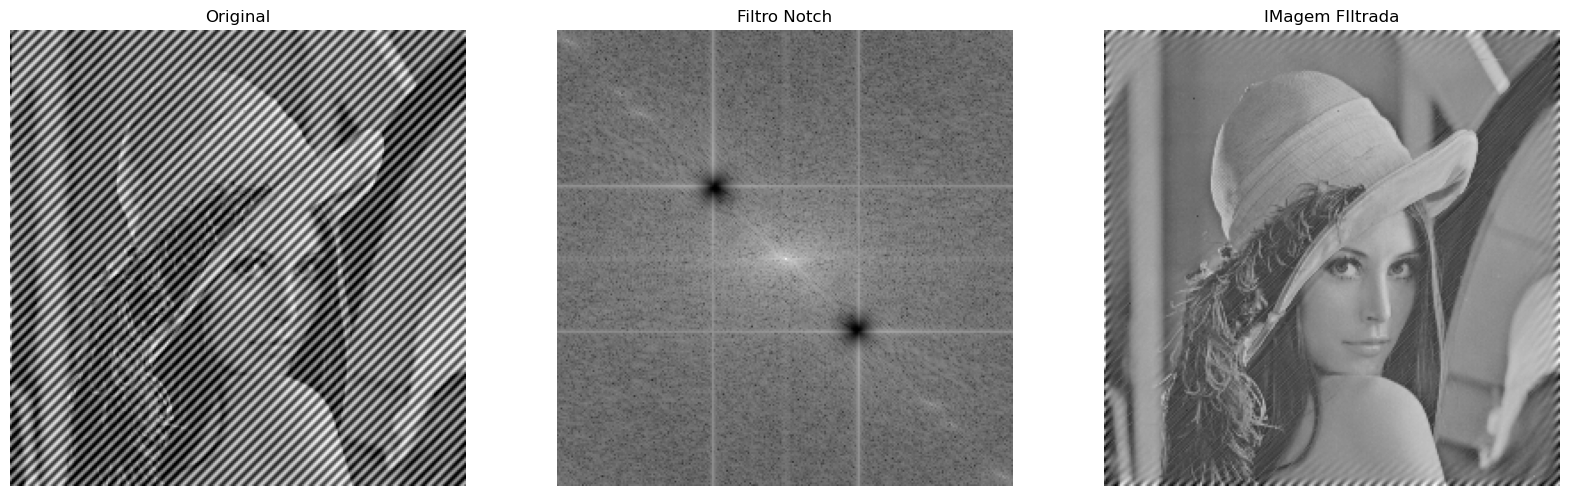

In [113]:
lenna = io.imread('https://drive.google.com/uc?id=1ExhUVoHaj2i4gN1UWC6U7RfP-boZhnRL', as_gray=True)
lin, col = lenna.shape[:2]
HN = mask_butterworth_notch(col, lin, 40, 3, 40, 40)
nimg, fimg = passa_freq(lenna, HN)

show([lenna, np.log(np.abs(fimg)+1), nimg], ['Original','Filtro Notch', 'IMagem FIltrada'])

# Questão 2
<p align="justify">
Repita o processo de remoção do ruído periódico da questão anterior utilizando os seguintes filtro passa-bandas: ideal, Butterworth e Gaussiano.
<p>

<p align="justify">
Filtro Ideal:
$$H(u,v) = \begin{cases}
0 & \text{se } D_0-\frac{W}{2} \leq D \leq D_0 + \frac{W}{2}\\
1 & \text{otherwise}
\end{cases} $$
<p>

<p align="justify">
Filtro Butterworth:
$$H(u,v) = \frac{1}{1 + \left(\frac{D.W}{D^2 - D_0^2}\right)^{2n}}$$
<p>

<p align="justify">
Filtro Gaussiano:
$$H(u,v) = 1 - e^{-  \left(\frac{D^2 - D_0^2}{D.W} \right)^2 }$$
<p>

In [114]:
def mask_ideal_band(width, height, d0, W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)

    H = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if ( (D[i,j] >= d0 - W/2) & (D[i,j] <= d0+W/2) ):
                H[i,j] = 0
            else:
                H[i,j] = 1
                
    return H

In [115]:
def mask_butterworth_band(width, height, d0, n, W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)

    H = 1 / (1 + ( (D*W)/(D**2 - d0**2) )**(2*n))

    return H

In [116]:
def mask_gaussian_band(width, height, d0,  W):
    U, V = gridFourier(width, height)
    D = np.sqrt(U**2 + V**2)
    e = np.exp( - ( (D**2 - d0**2)/(D*W) )**2 )

    H = 1 - e

    return H

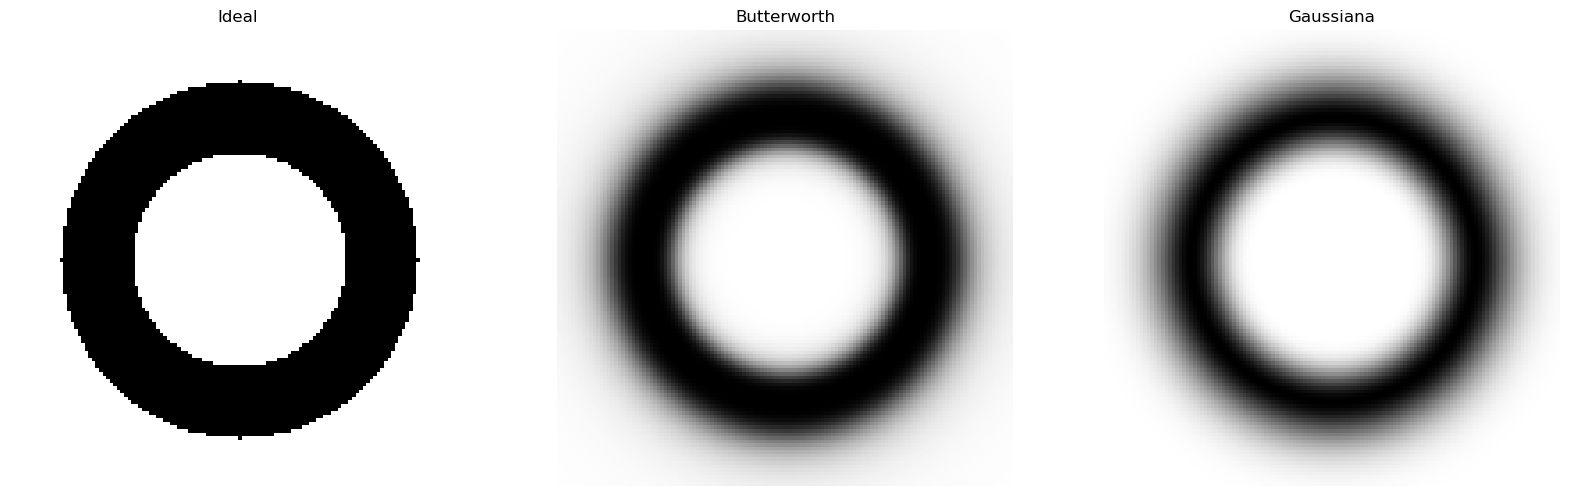

In [117]:
HI =  mask_ideal_band(128, 128, 40, 20)
HB =  mask_butterworth_band(128, 128, 40, 2, 20)
HG =  mask_gaussian_band(128, 128, 40, 20)
show([HI, HB, HG], ['Ideal','Butterworth', 'Gaussiana'])


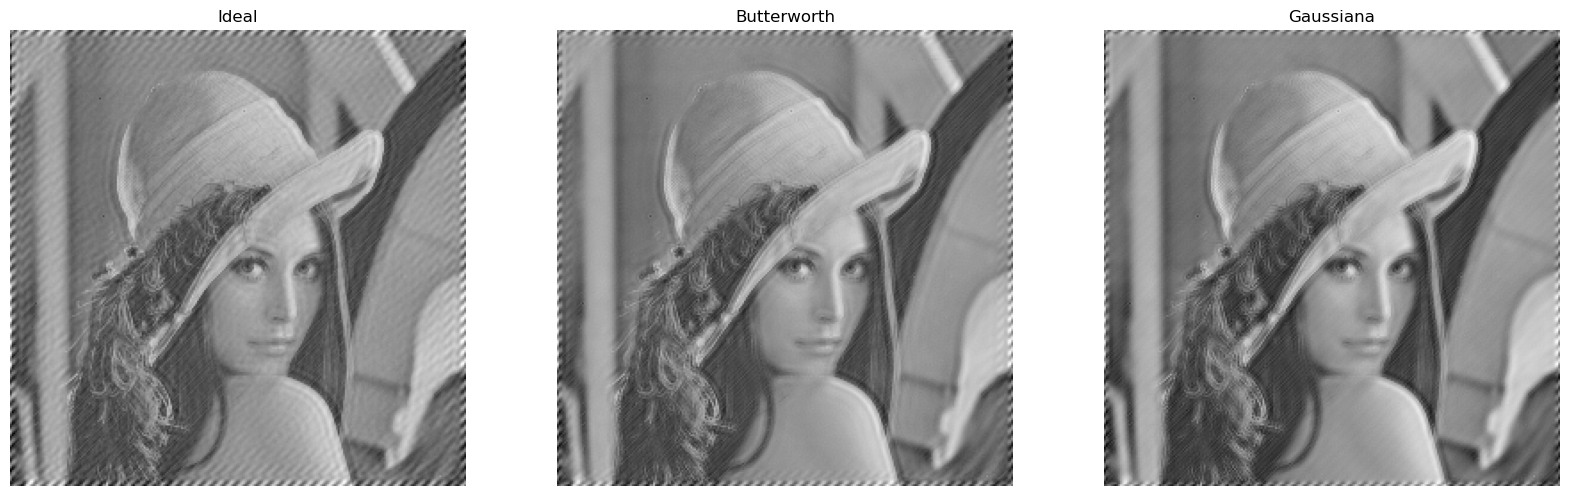

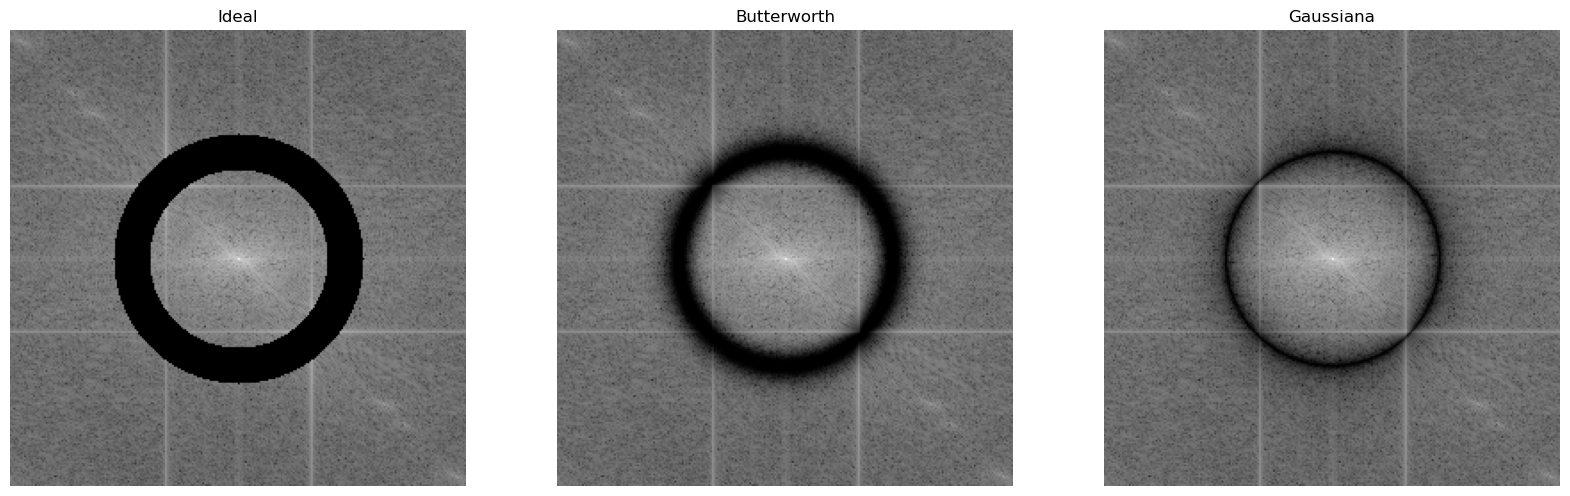

In [118]:
lenna = io.imread('https://drive.google.com/uc?id=1ExhUVoHaj2i4gN1UWC6U7RfP-boZhnRL', as_gray=True)
lin, col = lenna.shape[:2]

HI =  mask_ideal_band(col, lin, 60, 20)
HB =  mask_butterworth_band(col, lin, 60, 3, 30)
HG =  mask_gaussian_band(col, lin, 60, 50)
nimgI, fimgI = passa_freq(lenna, HI)
nimgB, fimgB= passa_freq(lenna, HB)
nimgG, fimgG = passa_freq(lenna, HG)

show([nimgI, nimgB, nimgG], ['Ideal','Butterworth', 'Gaussiana'])
show([np.log(np.abs(fimgI)+1), np.log(np.abs(fimgB)+1), np.log(np.abs(fimgG)+1)], ['Ideal','Butterworth', 'Gaussiana'])

## Questao 3
<p> A ideia principal do $\textit{unsharp masking}$ é que o desfoque da imagem remova os detalhes de uma imagem, mas se adicionarmos esses detalhes de volta à imagem dimensionada por um determinado fator, os detalhes seriam aprimorados e obteríamos uma imagem ``mais nítida''. O  $\textit{unsharp masking}$ é, portanto, definido como abaixo:
$$f + \alpha(f - f*g)$$
onde $f*g$ é a imagem suavizada, $f$ é a imagem original e $\alpha$ é um fator de escala. Implementar a função $\textit{unsharp masking}$
</p>

In [155]:
def mask_gaussiana(width, height, sigma):
    U, V = gridFourier(width, height)
    
    D = np.sqrt(U**2 + V**2)
    H = np.exp( - (D**2)/(2*sigma**2) )
    
    return H

In [200]:
def highboost(img, radio = 30, k = 1):
    height, width = img.shape[:2]
    gauss = mask_gaussiana(width, height, radio)
    fimg = fft.fftshift( fft.fft2(img) )
    fimg = fimg * gauss
    nimg = fft.ifft2(fimg)
    nimg = np.abs(nimg)
    nimg = img + (k*nimg)
    return nimg


TypeError: Image data of dtype complex128 cannot be converted to float

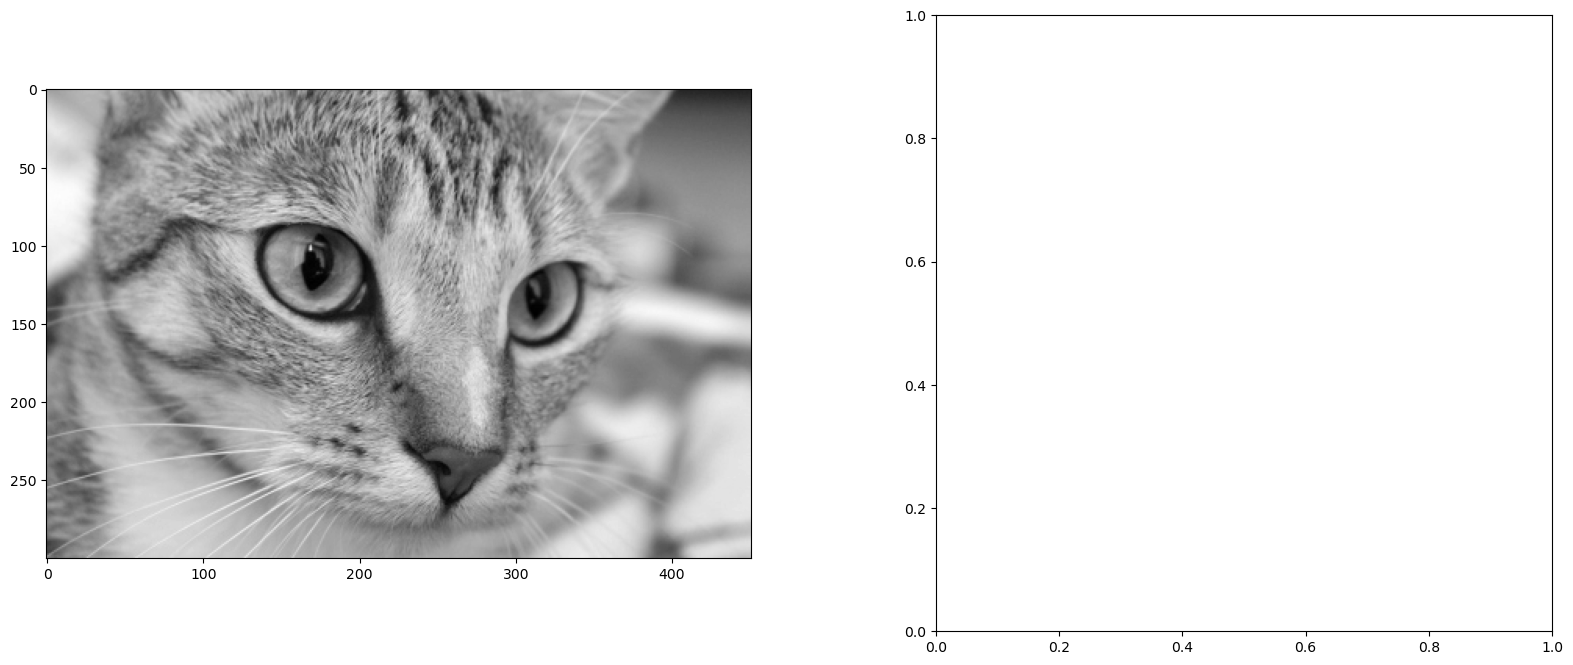

In [201]:
img = data.chelsea()
img = color.rgb2gray(img)
nimg = highboost(img, radio = 30, k = 5)

f, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(nimg, cmap='gray')

## Questao 4

<p>
Crie uma nova versão da seguinte imagem aplicando a função <i>modifica</i>
</p>
<img src="https://drive.google.com/uc?id=1lWiT-Wz7ZFhWRf-u__aqxwzaho6AtLG8" alt="Drawing"  width="300"/>
<p>
Logo, binarize a nova imagem gerada usando um filtro adaptativo.
</p>

In [122]:
def modifica(img):
  fimg = util.img_as_float(img, force_copy=True)
  lin, col = fimg.shape[:2]
  x = np.ones((lin,1)) @ np.arange(col).reshape(1,col)
  nimg = fimg * ( x/2 + 50 ) + (1-fimg) * x/2
  return mapping(nimg)

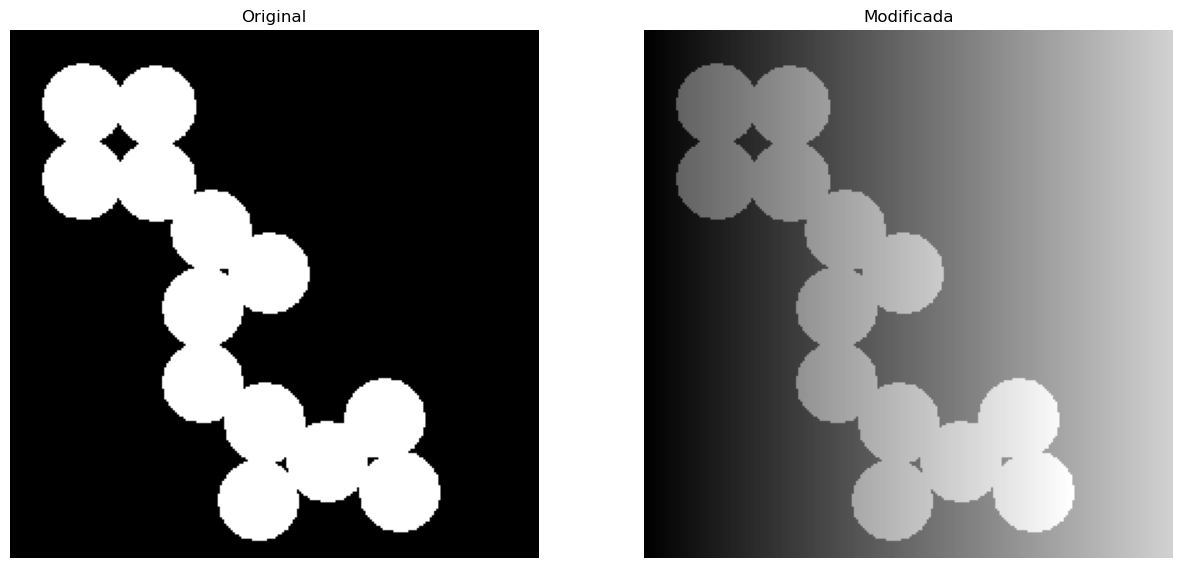

In [123]:
img = io.imread("https://drive.google.com/uc?id=1lWiT-Wz7ZFhWRf-u__aqxwzaho6AtLG8", as_gray=True)
nimg = modifica(img)
show([img, nimg], ['Original', 'Modificada'])

In [124]:
def segmentacao_adaptativa(img, blocos_x, blocos_y):
      fimg = util.img_as_float(img)
      lin, col = fimg.shape[:2]
      nimg = np.zeros((lin, col))
      for i in range(blocos_x):
         for j in range(blocos_y):
               x = i*lin//blocos_x
               y = j*col//blocos_y
               bloco = fimg[x:x+lin//blocos_x, y:y+col//blocos_y]
               limiar = filters.threshold_otsu(bloco)
               nimg[x:x+lin//blocos_x, y:y+col//blocos_y] = bloco > limiar
      return nimg


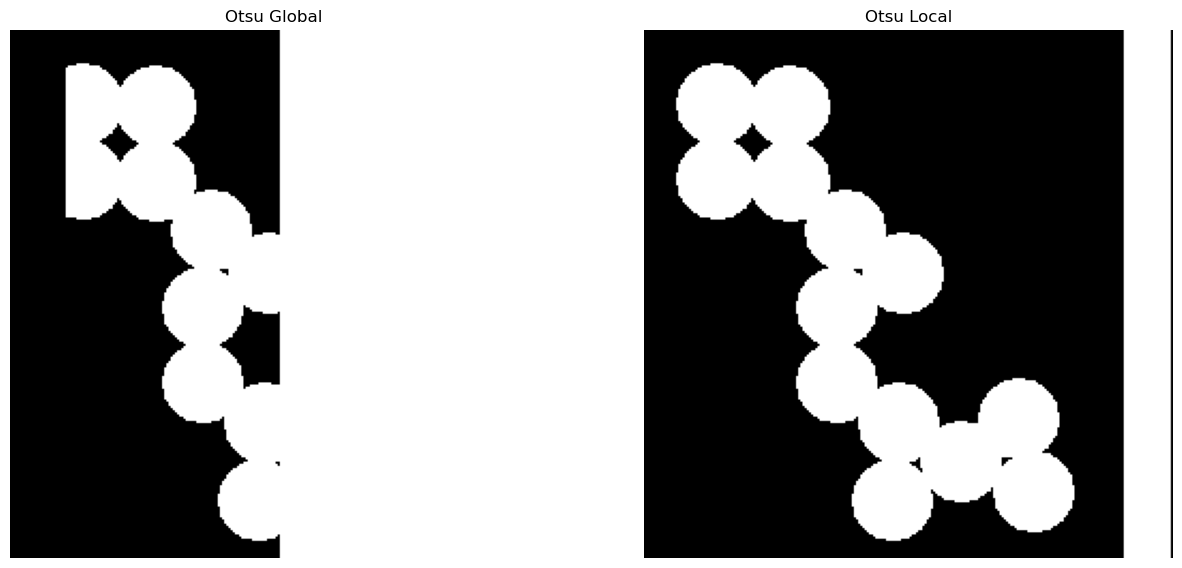

In [128]:
# encontrar os valores para blocos_x e blocos_y
nimg2 = segmentacao_adaptativa(nimg, blocos_x=1, blocos_y=6)
thresh = filters.threshold_otsu(nimg)
nimg3 = nimg > thresh
show([nimg3, nimg2], ['Otsu Global', 'Otsu Local'])